Using device: cpu

Epoch 1

CNN Test Accuracy: 98.35%
SNN Test Accuracy: 97.33%

Epoch 2

CNN Test Accuracy: 98.60%
SNN Test Accuracy: 97.85%

Epoch 3

CNN Test Accuracy: 98.91%
SNN Test Accuracy: 98.06%

Epoch 4

CNN Test Accuracy: 99.04%
SNN Test Accuracy: 98.52%

Epoch 5

CNN Test Accuracy: 98.83%
SNN Test Accuracy: 98.37%


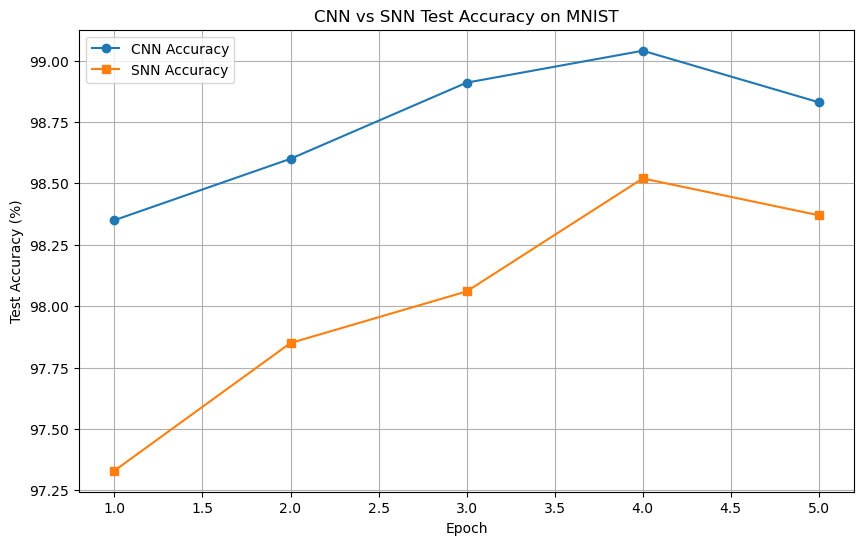

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import snntorch as snn
from snntorch import surrogate
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation
batch_size = 32

# Transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# MNIST Dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data Loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# CNN Model Definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        # Fully Connected Layers
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)

        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.conv1(x))  # [batch_size, 16, 28, 28]
        x = self.pool1(x)             # [batch_size, 16, 14, 14]
        x = self.relu(self.conv2(x))  # [batch_size, 32, 14, 14]
        x = self.pool2(x)             # [batch_size, 32, 7, 7]
        x = x.view(x.size(0), -1)     # Flatten to [batch_size, 32*7*7]
        x = self.relu(self.fc1(x))    # [batch_size, 64]
        x = self.fc2(x)               # [batch_size, 10]
        return x

# SNN Model Definition
class SNN(nn.Module):
    def __init__(self, num_steps=10):
        super(SNN, self).__init__()
        self.num_steps = num_steps

        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 10)

        # Spiking Neurons
        self.lif1 = snn.Leaky(beta=0.9, spike_grad=surrogate.fast_sigmoid(slope=25))
        self.lif2 = snn.Leaky(beta=0.9, spike_grad=surrogate.fast_sigmoid(slope=25))
        self.lif3 = snn.Leaky(beta=0.9, spike_grad=surrogate.fast_sigmoid(slope=25))
        self.lif4 = snn.Leaky(beta=0.9, spike_grad=surrogate.fast_sigmoid(slope=25))

    def forward(self, x):
        batch_size = x.size(0)
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        mem4 = self.lif4.init_leaky()

        # Poisson Encoding
        spike_probs = torch.rand((self.num_steps, batch_size, 1, 28, 28), device=x.device)
        x = x.unsqueeze(0).repeat(self.num_steps, 1, 1, 1, 1)
        x = (spike_probs < x).float()

        spk_out = []

        for step in range(self.num_steps):
            input_spike = x[step]

            # Conv Layer 1
            cur1 = self.conv1(input_spike)
            mem1, spk1 = self.lif1(cur1, mem1)

            # Pooling Layer 1
            spk1 = self.pool1(spk1)

            # Conv Layer 2
            cur2 = self.conv2(spk1)
            mem2, spk2 = self.lif2(cur2, mem2)

            # Pooling Layer 2
            spk2 = self.pool2(spk2)

            # Flatten
            spk2_flat = spk2.view(spk2.size(0), -1)

            # Fully Connected Layer 1
            cur3 = self.fc1(spk2_flat)
            mem3, spk3 = self.lif3(cur3, mem3)

            # Fully Connected Layer 2
            cur4 = self.fc2(spk3)
            mem4, spk4 = self.lif4(cur4, mem4)

            spk_out.append(spk4)

        out = torch.stack(spk_out).mean(dim=0)  # Average over time steps
        return out

# Training and Evaluation Functions
def train_model(model, device, train_loader, optimizer, criterion, model_type='CNN'):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

def evaluate_model(model, device, test_loader, model_type='CNN'):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    accuracy = accuracy_score(all_targets, all_preds)
    return accuracy

# Instantiate Models
cnn_model = CNN().to(device)
snn_model = SNN(num_steps=10).to(device)  # Reduced num_steps for faster training

# Loss and Optimizers
criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
snn_optimizer = optim.Adam(snn_model.parameters(), lr=0.001)

# Training Parameters
epochs = 5  # Increased epochs for plotting

# Lists to Store Accuracies
cnn_accuracies = []
snn_accuracies = []

# Training and Evaluation Loops
for epoch in range(1, epochs + 1):
    print(f'\nEpoch {epoch}\n')
    # Train CNN
    train_model(cnn_model, device, train_loader, cnn_optimizer, criterion, model_type='CNN')
    cnn_acc = evaluate_model(cnn_model, device, test_loader, model_type='CNN')
    cnn_accuracies.append(cnn_acc)
    print(f'CNN Test Accuracy: {cnn_acc * 100:.2f}%')

    # Train SNN
    train_model(snn_model, device, train_loader, snn_optimizer, criterion, model_type='SNN')
    snn_acc = evaluate_model(snn_model, device, test_loader, model_type='SNN')
    snn_accuracies.append(snn_acc)
    print(f'SNN Test Accuracy: {snn_acc * 100:.2f}%')

# Plotting Accuracies
plt.figure(figsize=(10,6))
plt.plot(range(1, epochs + 1), [acc * 100 for acc in cnn_accuracies], marker='o', label='CNN Accuracy')
plt.plot(range(1, epochs + 1), [acc * 100 for acc in snn_accuracies], marker='s', label='SNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('CNN vs SNN Test Accuracy on MNIST')
plt.legend()
plt.grid(True)
plt.show()